In [40]:
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import numpy as np
from b0.synth import (
    labels_to_chi, chi_to_fieldmap, fieldmap_to_shift, ppm_to_hz, shim)

In [41]:
aseg = f'samseg_talairach.mgz'

dat = nib.load(aseg)
dat = np.asarray(dat.dataobj).squeeze().astype('long')
dat = torch.as_tensor(dat)      # oriented [R A S]
zdim = -2                       # assumes B0 along A/P

In [42]:
from matplotlib.colors import ListedColormap

cmap = np.zeros([300, 4])
cmap[1, :3] = cmap[41, :3] = [70, 130, 180]         # Cerebral-Exterior
cmap[2, :3] = cmap[42, :3] = [245, 245, 245]        # Cerebral-White-Matter
cmap[3, :3] = cmap[43, :3] = [205, 62, 78]          # Cerebral-Cortex
cmap[4, :3] = cmap[44, :3] = [120, 18, 134]         # Lateral-Ventricle
cmap[5, :3] = cmap[45, :3] = [196, 58, 250]         # Inf-Lat-Vent
cmap[7, :3] = cmap[46, :3] = [220, 248, 164]        # Cerebellum-White-Matter
cmap[8, :3] = cmap[47, :3] = [230, 148, 34]         # Cerebellum-Cortex
cmap[10, :3] = cmap[49, :3] = [0, 118, 14]          # Thalamus
cmap[11, :3] = cmap[50, :3] = [122, 186, 220]       # Caudate
cmap[12, :3] = cmap[51, :3] = [236, 13, 176]        # Putamen
cmap[13, :3] = cmap[52, :3] = [12, 48, 255]         # Pallidum
cmap[14, :3] = [204, 182, 142]                      # 3rd-Ventricle
cmap[15, :3] = [42, 204, 164]                       # 4th-Ventricle
cmap[16, :3] = [119, 159, 176]                      # Brain-Stem
cmap[17, :3] = cmap[53, :3] = [220, 216, 20]        # Hippocampus
cmap[18, :3] = cmap[54, :3] = [103, 255, 255]       # Amygdala
cmap[24, :3] = [60, 60, 60]                         # CSF
cmap[26, :3] = cmap[58, :3] = [255, 165, 0]         # Accumbens-Area
cmap[28, :3] = cmap[60, :3] = [165, 42, 42]         # VentralDC
cmap[30, :3] = cmap[62, :3] = [160, 32, 240]        # vessel
cmap[31, :3] = cmap[63, :3] = [0, 200, 200]         # Choroid-plexus
cmap[72, :3] = [120, 190, 150]                      # 5th-Ventricle
cmap[77, :3] = [200, 70, 255]                       # WM-hypointensities
cmap[80, :3] = [164, 108, 226]                      # non-WM-hypointensities
cmap[85, :3] = [234, 169, 30]                       # Optic-Chiasm
cmap[165, :3] = [120, 120, 120]                     # Skull
cmap[258, :3] = [150, 150, 200]                     # Head-ExtraCerebral
cmap[259, :3] = [60, 60, 60]                        # Eye-Fluid

cmap[:, -1] = 255
cmap /= 255
cmap = ListedColormap(cmap)

In [43]:
# SAMSEG to Chi

chi_map = dict()
for i in range(300):
    chi_map[i] = 'water'
chi_map[0] = 'air'
chi_map[165] = 'bone'
chi_map[10] = chi_map[49] = 'th'
chi_map[11] = chi_map[50] = 'cn'
chi_map[12] = chi_map[51] = 'pu'
chi_map[13] = chi_map[52] = 'gp'


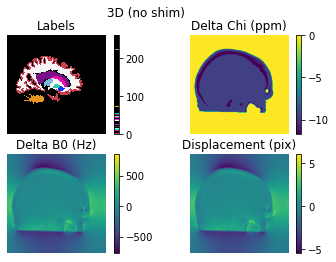

In [44]:
### 3D // no shim

chi = labels_to_chi(dat, chi_map)
fmap = chi_to_fieldmap(chi, dim=3, zdim=zdim)   # Assumes 1mm voxel
fmap = ppm_to_hz(fmap)                          # Assumes 3T / 1H
dmap = fieldmap_to_shift(fmap)                  # Assumes 140Hz/pix bandwidth

x = 148

plt.subplot(2, 2, 1)
plt.imshow(dat[x], cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('3D (no shim)')
plt.show()

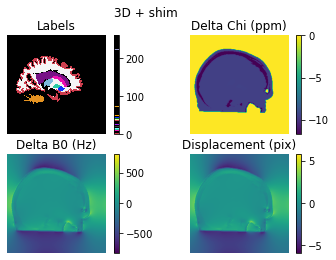

In [45]:
### 3D // with shim


chi = labels_to_chi(dat, chi_map)
fmap = chi_to_fieldmap(chi, dim=3, zdim=zdim)   # Assumes 1mm voxel
fmap = shim(fmap, mask=dat > 0, dim=3)          # Minimize grad in mask
fmap = ppm_to_hz(fmap)                          # Assumes 3T / 1H
dmap = fieldmap_to_shift(fmap)                  # Assumes 140Hz/pix bandwidth

x = 148

plt.subplot(2, 2, 1)
plt.imshow(dat[x], cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('3D + shim')
plt.show()


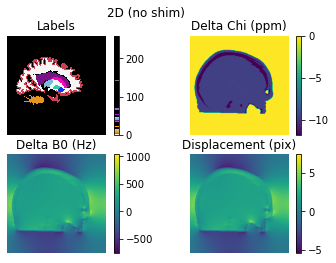

In [46]:
### 2D

x = 148
dat = dat[x]
chi = labels_to_chi(dat, chi_map)
fmap = chi_to_fieldmap(chi, dim=2, zdim=zdim)
fmap = ppm_to_hz(fmap)
dmap = fieldmap_to_shift(fmap)


plt.subplot(2, 2, 1)
plt.imshow(dat, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi)
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap)
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap)
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('2D (no shim)')
plt.show()